In [17]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import statsmodels.formula.api as smf
from scipy import stats
from pandas.stats.api import ols
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
train = pd.read_csv('Data/train.csv')

In [23]:
all_data = train.loc[:,'MSSubClass':'SaleCondition']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110f75a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110241810>]], dtype=object)

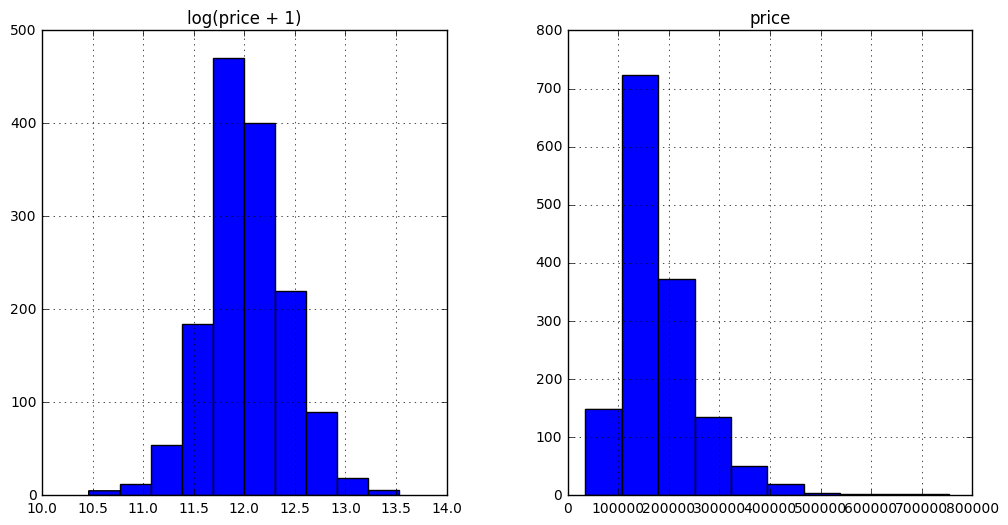

In [24]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [25]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [26]:
all_data = pd.get_dummies(all_data)

In [27]:
all_data = all_data.fillna(all_data.mean())

In [28]:
X_train = all_data[:train.shape[0]]
y = train.SalePrice

In [29]:
X_train_all = pd.concat([X_train, y],axis=1)

In [30]:
def Regularization_fit_lambda(model,X_train,y_train,lambdas,p=0.4,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #lambdas: a list of lambda values to try
    #p: ratio of the validation sample size / total training size
    #Graph: plot the graph of R^2 values for different lambda

    R_2_OS=[]
    X_train0, X_valid, y_train0, y_valid = train_test_split(X_train,
                                    y_train, test_size = 0.4, random_state = 200)

    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_lambda = lambdas[0]
    
    for i in lambdas:
        lm = RM(i)
        lm.fit(X_train0,y_train0)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_lambda = i
    
    if Graph==True:
        plt.title('IS R-squared vs OS-R-squared for different Lambda')
        if logl:
            plt.xlabel('ln(Lambda)')
            l=log(lambdas)
            bl=log(best_lambda)
        else:
            plt.xlabel('Lambda')
            l=lambdas
            bl=best_lambda
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return best_lambda

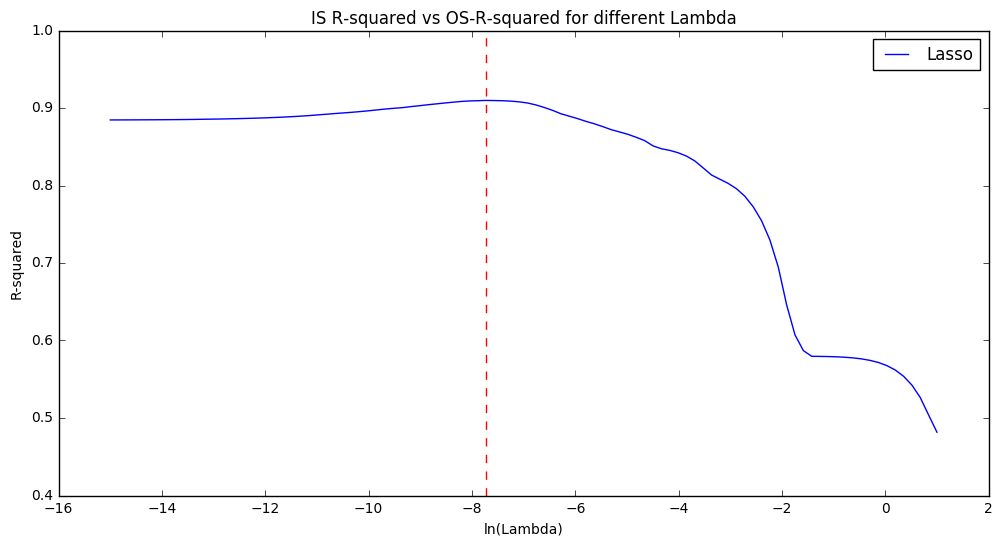

Optimal lambda for Lasso=0.000440644236841


In [31]:
lambdas = np.linspace(-15,1,100)
lambdas=[math.exp(i) for i in lambdas]
lambda_l_optimal=Regularization_fit_lambda(2,X_train,y,lambdas,p=0.4,Graph=True,logl=True)
print('Optimal lambda for Lasso={0}'.format(lambda_l_optimal))

In [33]:
X_train_all.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,1,0,0,0,0,1,0,12.247699
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,1,0,0,0,0,1,0,12.109016
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,1,0,0,0,0,1,0,12.317171
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,1,1,0,0,0,0,0,11.849405
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,1,0,0,0,0,1,0,12.429220


In [36]:
var=len(X_train_all)
p=0.7
X=X_train_all
np.random.seed(324)
train_index=np.random.choice(range(len(X)),len(X)*7/10,replace=False)
test_index=[x for x in range(len(X)) if x not in train_index]
data_train=X_train_all.iloc[train_index]
#Data for predicting
data_test=X_train_all.iloc[test_index]
X_train1=np.matrix(data_train.iloc[:,:288])
y_train=np.array(data_train['SalePrice'])
X_test1=np.matrix(data_test.iloc[:,:288])
y_test=np.array(data_test['SalePrice'])

In [37]:
Lasso=linear_model.Lasso(fit_intercept=True,alpha=lambda_l_optimal)
Lasso.fit(X_train1,y_train)
p_IS=Lasso.predict(X_train1)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)

p_OS=Lasso.predict(X_test1)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.936129434739
The R-squared we found for OS Lasso is: 0.919753157263


In [38]:
model_lasso =linear_model.Lasso(fit_intercept=True,alpha=lambda_l_optimal).fit(X_train,y)

In [39]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [40]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 117 variables and eliminated the other 171 variables


In [41]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

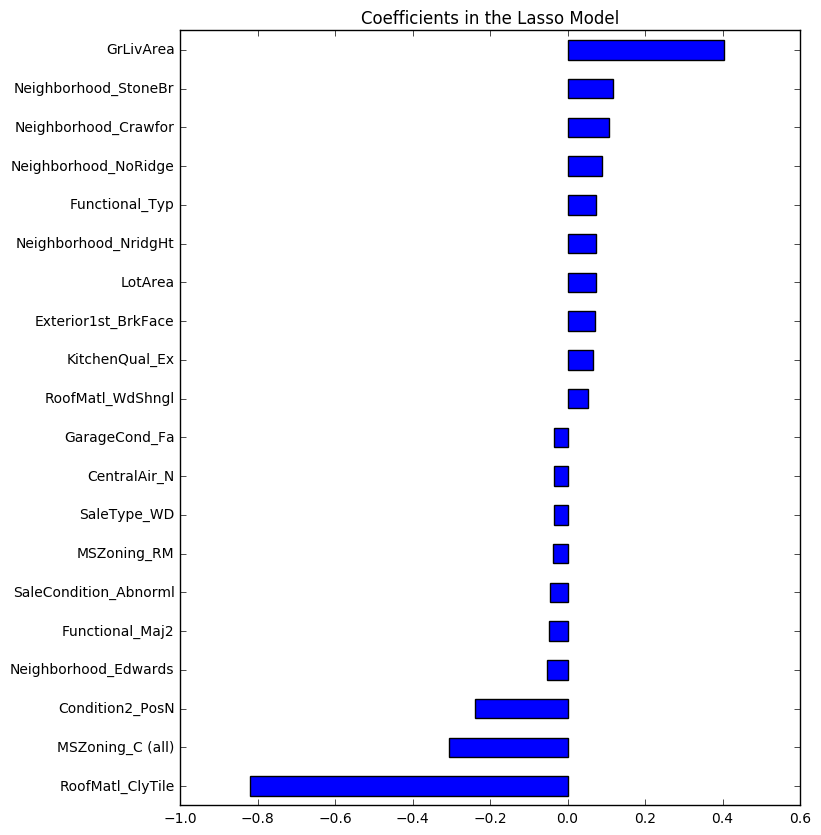

In [42]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [43]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]

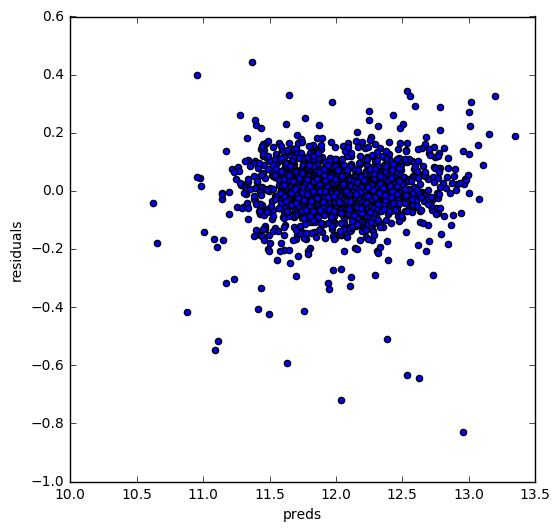

In [44]:
preds.plot(x = "preds", y = "residuals",kind = "scatter")